<a href="https://colab.research.google.com/github/AlexAlexeyuk/Alexander.Alexeyuk/blob/ready/stat_ml_begining_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu,ttest_ind, kruskal,chisquare, pearsonr, spearmanr
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/content/covid_data.csv')
df = df.drop('Unnamed: 0', axis=1)

# **<span style="color:#6daa9f;">Анализ данных</span>**

Визуализация данных


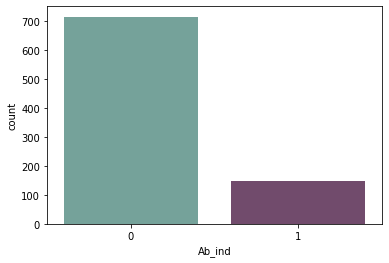

In [3]:
#Посмотрим на баланс данных 
cols= ["#6daa9f","#774571"]
sns.countplot(x= df["Ab_ind"], palette= cols)

In [4]:
neg, pos = np.bincount(df['Ab_ind'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 863
    Positive: 148 (17.15% of total)



Отметим, что данные несбалансированы

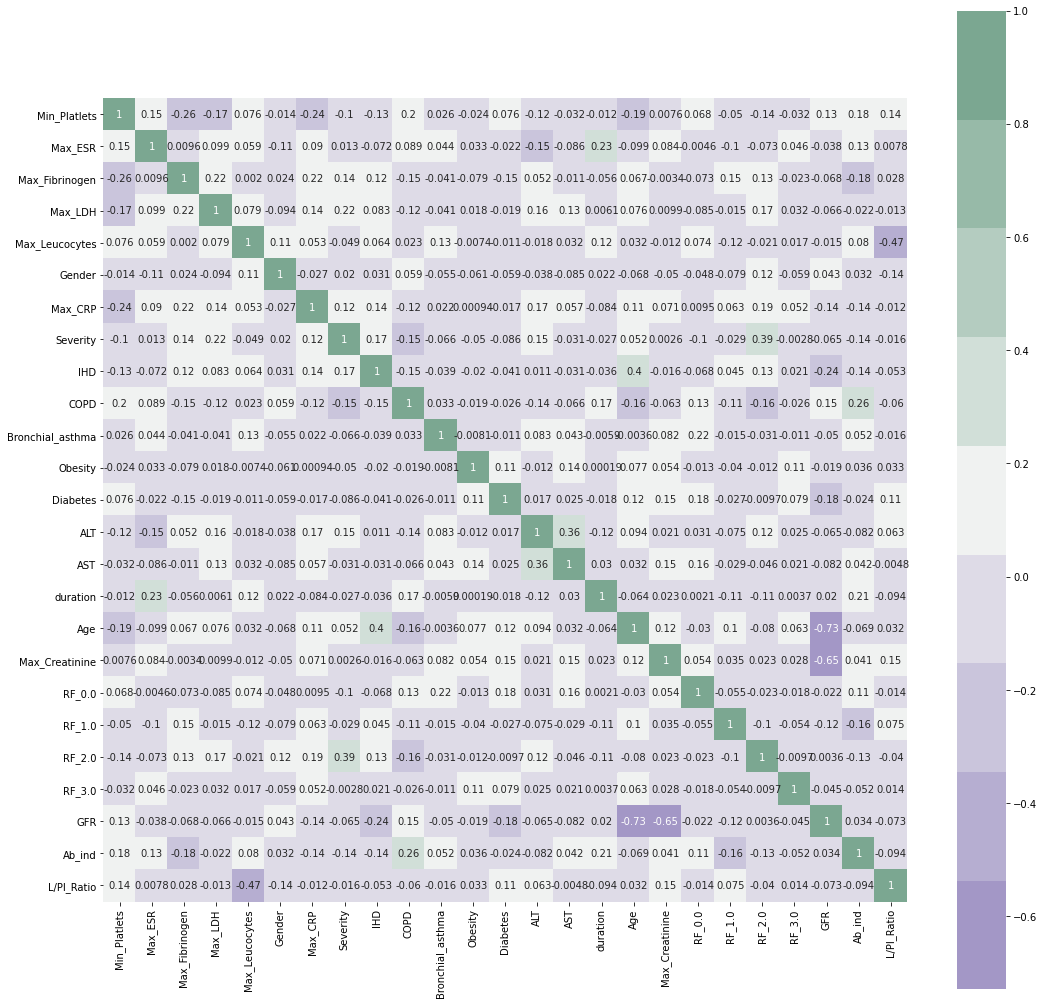

In [5]:
#Построим корреляционную матрицу
cmap = sns.diverging_palette(275,150,  s=40, l=65, n=9)
corrmat = df.corr()
plt.subplots(figsize=(18, 18))
sns.heatmap(corrmat, cmap= cmap, annot=True, square=True);

In [ ]:
# построим ящичковые диагнаммы с рассеянием
feature = ['Min_Platlets', 'Max_ESR', 'Max_Fibrinogen', 'Max_LDH',
       'Max_Leucocytes',  'Max_CRP','Max_Creatinine','GFR','L/Pl_Ratio']
for i in feature:
    plt.figure(figsize=(8,8))
    sns.swarmplot(x=df["Ab_ind"], y=df[i], color="black", alpha=0.5)
    sns.boxenplot(x=df["Ab_ind"], y=df[i], palette=cols)
    plt.show()

Итак, какие выводы:

1) В основном данные распределены ненормально
2) Визуально есть различия между группами с показаниями и без показаний к назначению антибиотиков
3) Дальнейший стат.анализ поможет сказать более уверенно

In [ ]:
sns.kdeplot(x=df['Max_LDH'], y=df["Age"], hue=df["Ab_inf"], palette=cols)

In [ ]:
columns =['Min_Platlets', 'Max_ESR', 'Max_Fibrinogen', 'Max_LDH',
       'Max_Leucocytes',  'Max_CRP','Max_Creatinine','GFR','L/Pl_Ratio']

In [ ]:
df_no_ind = df[df['Ab_ind'] == 0]
df_ind = df[df['Ab_ind'] == 1]



---
## Классические статистические тесты


## Проверим подвыборка на нормальность распределения.
Нулевая гипотеза в этом случае: данные распределены нормально. p-value в данном случае, показывает вероятность ошибиться в случает, если мы отвергнем нулевую гипотезу.

In [ ]:
for i in columns:
  lst1 = df_no_ind[i]
  lst2 = df_ind[i]
  shapiro_test = stats.shapiro(lst1) # тест шапиро-уилка
  shapiro_test2 = stats.shapiro(lst2) # тест шапиро-уилка
  if shapiro_test[1] < .05:
    print('Данные {0} распределены ненормально,\
           p-value - {1}'.format(i,  shapiro_test[1]))
  if shapiro_test2[1] < .05:
    print('Данные {0} распределены ненормально,\
           p-value - {1}'.format(i,  shapiro_test2[1]))
  else:
    pass

Данные Min_Platlets распределены ненормально,           p-value - 2.2496317308995373e-11
Данные Min_Platlets распределены ненормально,           p-value - 0.0046564731746912
Данные Max_ESR распределены ненормально,           p-value - 2.552094656493864e-06
Данные Max_ESR распределены ненормально,           p-value - 2.1818234017700888e-05
Данные Max_Fibrinogen распределены ненормально,           p-value - 8.701200213717984e-17
Данные Max_Fibrinogen распределены ненормально,           p-value - 4.6909113734727725e-05
Данные Max_LDH распределены ненормально,           p-value - 1.7956045894607087e-07
Данные Max_LDH распределены ненормально,           p-value - 0.0016341493465006351
Данные Max_Leucocytes распределены ненормально,           p-value - 1.087012632683404e-10
Данные Max_Leucocytes распределены ненормально,           p-value - 1.7819214159775498e-10
Данные Max_CRP распределены ненормально,           p-value - 5.4264262484617843e-17
Данные Max_CRP распределены ненормально,      

p-value ниже 0.05, т.о мы отвергаем нулевую гипотезу о нормальности распределения и будем работать с данными используя непараметрические стат.методы

In [ ]:
def Basic_statistics(lst_1, lst_2):
    """ 
    Функция "Базовые статистики"

    На вход получает 2 списка данных для сравнения.
    На выходе получаем p-values, при сравнении признаков. 
    В частности: показаны, не показаны антибиотики
    """
    res_mw = mannwhitneyu(lst_1, lst_2, 
                       use_continuity=True, 
                       alternative=None) # u -тест манна-уитни
    res_kw = kruskal(lst_1, lst_2)## краскела уолиса
    anova = stats.f_oneway(lst_1, lst_2) #тест анова
    return res_mw[1], res_kw[1],  anova[1]
for col in columns:
  lst1 = df_no_ind[col]
  lst2 = df_ind[col]
  mw =  Basic_statistics(lst1, lst2)[0]
  kw =  Basic_statistics(lst1, lst2)[1]
  an =  Basic_statistics(lst1, lst2)[2]
  if mw < .05:
    print('Данные {0} статисически значимо различаются в подгруппах,\
           p-value - {1}, тест Манна-Уитни'.format(col,  mw))
  if kw < .05:
    print('Данные {0} статисически значимо различаются в подгруппах,\
           p-value - {1}, тест Крускала-Уоллиса'.format(col,  kw))
  if an < .05:
    print('Данные {0} статисически значимо различаются в подгруппах,\
           p-value - {1}, тест Анова'.format(col,  an))
  else:
    pass


Данные Min_Platlets статисически значимо различаются в подгруппах,           p-value - 3.2855745293407934e-07, тест Манна-Уитни
Данные Min_Platlets статисически значимо различаются в подгруппах,           p-value - 6.565008618092226e-07, тест Крускала-Уоллиса
Данные Min_Platlets статисически значимо различаются в подгруппах,           p-value - 2.2212869639839813e-07, тест Анова
Данные Max_ESR статисически значимо различаются в подгруппах,           p-value - 6.572563797722308e-05, тест Манна-Уитни
Данные Max_ESR статисически значимо различаются в подгруппах,           p-value - 0.00013135466386457627, тест Крускала-Уоллиса
Данные Max_ESR статисически значимо различаются в подгруппах,           p-value - 0.00011784582665018135, тест Анова
Данные Max_Fibrinogen статисически значимо различаются в подгруппах,           p-value - 9.701834609290562e-06, тест Манна-Уитни
Данные Max_Fibrinogen статисически значимо различаются в подгруппах,           p-value - 1.9387907471511455e-05, тест Крус

## Модели машинного обучения

In [ ]:
!pip install h2o
import h2o
h2o.init()
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2OIsolationForestEstimator
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators import H2OSupportVectorMachineEstimator
from h2o.grid.grid_search import H2OGridSearch

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ------------------------------------------------------------------
H2O_cluster_uptime:         3 hours 20 mins
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.32.0.4
H2O_cluster_version_age:    19 days
H2O_cluster_name:           H2O_from_python_unknownUser_m1njlv
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    2.902 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.6.9 final
--------------------------  ------------------------------------------------------------------

In [ ]:
def pipeline_gbm_grid(data, target_column,  split_ratio):
    data = h2o.H2OFrame(data)
    predictors = data.col_names
    predictors.remove(target_column)
    data[target_column] = data[target_column].asfactor()
    train, valid, test = data.split_frame(seed = 12345, ratios = split_ratio)
    target = target_column
    hyperparams_tune = {
    'max_depth' : list(range(2, 6, 1)),
    'sample_rate' : [x/100. for x in range(20,101)],
    'col_sample_rate' : [x/100. for x in range(20,101)],
    'min_split_improvement': [0, 1e-8, 1e-6, 1e-4]}

    search_criteria_tune = {
    'strategy' : "RandomDiscrete",
    'max_runtime_secs' : 300,  ## limit the runtime to 5 minutes
    'max_models' : 15,  ## build no more than 15 models
    'stopping_rounds' : 5,
    'stopping_metric' : "AUC",
    'stopping_tolerance': 1e-3}
    gbm_final_grid = H2OGradientBoostingEstimator(
    ## More trees is better if the learning rate is small enough
    ## we use "more than enough" trees with early stopping
    ntrees = 10000,
    ## we use learn rate with annealing for a fast scan
    learn_rate = 0.05,
    learn_rate_annealing = 0.99,
    ## Score every 10 trees to make early stopping reproducible
    score_tree_interval = 10,
    ## Set seed for reproducibility
    seed = 12345,
    ## Balansing of classes
    balance_classes = True,
    keep_cross_validation_predictions = True)
    final_grid = H2OGridSearch(
    gbm_final_grid,
    hyper_params = hyperparams_tune,
    search_criteria = search_criteria_tune)
    final_grid.train(x = predictors,
           y = target,
           training_frame = train,
           validation_frame = valid, 
           max_runtime_secs = 180) # can override setting in search_criteria_tune
    sorted_gbm_grid = final_grid.get_grid(sort_by = 'auc', decreasing = True)
    best_gbm = sorted_gbm_grid.models[0]
    best_gbm_perf_valid = best_gbm.model_performance(valid)
    best_gbm_perf_test = best_gbm.model_performance(test)
    params_list = []
    for key, value in best_gbm.params.items():
      params_list.append(str(key)+" = "+str(value['actual']))
    return  best_gbm_perf_valid#best_gbm_perf_valid.aucpr(), best_gbm_perf_test.aucpr(), params_list

In [ ]:
pipeline_gbm_grid(data = df, target_column = 'Ab_ind', cols_to_remove = 'Ab_ind', split_ratio = [.7, .15])

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.10186103705021149
RMSE: 0.31915675936788723
LogLoss: 0.3376416920930951
Mean Per-Class Error: 0.25952075310226785
AUC: 0.7847667950363714
AUCPR: 0.331171773862001
Gini: 0.5695335900727427

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11930284380010989: 


0     1   Error           Rate
0      0   98.0  25.0  0.2033   (25.0/123.0)
1      1    6.0  13.0  0.3158     (6.0/19.0)
2  Total  104.0  38.0  0.2183   (31.0/142.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold       value    idx
0                        max f1   0.119303    0.456140   37.0
1                        max f2   0.067548    0.583942   60.0
2                  max f0point5   0.259743    0.439560   17.0
3                  max accuracy   0.560944    0.866197    3.0
4                 max precision   0.560944    0.500000    3.0
5                    max recall   0.015485    1.000000  127.0
6               max specificity   0.594685    0.991870    0.0
7              max absolute_mcc   0.119303    0.369852   37.0
8    max min_per_class_accuracy   0.096911    0.731707   46.0
9   max mean_per_class_accuracy   0.119303    0.740479   37.0
10                      max tns   0.594685  122.000000    0.0
11                      max fns   0.594685   19.000000    0.0
12                      max fps   0.003418  123.000000  141.0
13                      max tps   0.015485   19.000000  127.0
14                      max tnr   0.594685    0.991870    0.0
15                      max fnr   0.594685    1.000000    0.0
16                      max fpr   0.003418    1.000000  141.0
17                      max tpr   0.015485    1.000000  127.0


Gains/Lift Table: Avg response rate: 13.38 %, avg score: 10.99 %


group  cumulative_data_fraction  ...  cumulative_gain  kolmogorov_smirnov
0       1                  0.014085  ...      -100.000000           -0.016260
1       2                  0.021127  ...       149.122807            0.036371
2       3                  0.035211  ...       198.947368            0.080873
3       4                  0.042254  ...       149.122807            0.072743
4       5                  0.056338  ...       180.263158            0.117244
5       6                  0.105634  ...       198.947368            0.242619
6       7                  0.154930  ...       205.741627            0.367993
7       8                  0.204225  ...       157.713249            0.371844
8       9                  0.302817  ...       125.948592            0.440308
9      10                  0.401408  ...        96.675900            0.448010
10     11                  0.500000  ...        78.947368            0.455712
11     12                  0.598592  ...        49.473684            0.341891
12     13                  0.697183  ...        35.885167            0.288832
13     14                  0.795775  ...        19.049837            0.175011
14     15                  0.894366  ...         5.926233            0.061190
15     16                  1.000000  ...         0.000000            0.000000

[16 rows x 14 columns]

In [ ]:
def pipeline_xgb_grid(data, target_column, cols_to_remove, split_ratio):
    data = h2o.H2OFrame(data)
    predictors = data.col_names
    predictors.remove(target_column)
    data[target_column] = data[target_column].asfactor()
    #data = data.drop(cols_to_remove)
    train, valid, test = data.split_frame(seed = 12345, ratios = split_ratio)
    target = target_column
    hyperparams_tune = {
    'max_depth' : list(range(2, 6, 1)),
    'sample_rate' : [x/100. for x in range(20,101)],
    'col_sample_rate' : [x/100. for x in range(20,101)],
    'min_split_improvement': [0, 1e-8, 1e-6, 1e-4]}

    search_criteria_tune = {
    'strategy' : "RandomDiscrete",
    'max_runtime_secs' : 300,  ## limit the runtime to 5 minutes
    'max_models' : 15,  ## build no more than 15 models
    'stopping_rounds' : 5,
    'stopping_metric' : "AUC",
    'stopping_tolerance': 1e-3}
    xgb_final_grid = H2OGradientBoostingEstimator(
    ## More trees is better if the learning rate is small enough
    ## we use "more than enough" trees with early stopping
    ntrees = 10000,
    ## we use learn rate with annealing for a fast scan
    learn_rate = 0.05,
    learn_rate_annealing = 0.99,
    ## Score every 10 trees to make early stopping reproducible
    score_tree_interval = 10,
    ## Set seed for reproducibility
    seed = 12345,
    ## Balansing of classes
    balance_classes = True,
    keep_cross_validation_predictions = True)
    final_grid = H2OGridSearch(
    xgb_final_grid,
    hyper_params = hyperparams_tune,
    search_criteria = search_criteria_tune)
    final_grid.train(x = predictors,
           y = target,
           training_frame = train,
           validation_frame = valid, 
           max_runtime_secs = 180) # can override setting in search_criteria_tune
    sorted_xgb_grid = final_grid.get_grid(sort_by = 'auc', decreasing = True)
    best_xgb = sorted_xgb_grid.models[0]
    best_xgb_perf_valid = best_xgb.model_performance(valid)
    best_xgb_perf_test = best_xgb.model_performance(test)
    params_list = []
    for key, value in best_xgb.params.items():
      params_list.append(str(key)+" = "+str(value['actual']))
    return  best_xgb_perf_valid#best_xgb_perf_valid.aucpr(), best_xgb_perf_test.aucpr(), params_list

In [ ]:
pipeline_xgb_grid(data = df, target_column = 'Ab_ind',  split_ratio = [.7, .15])

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.10291252754461808
RMSE: 0.32079982472660123
LogLoss: 0.3387290850456454
Mean Per-Class Error: 0.24753958065896442
AUC: 0.7770646127513907
AUCPR: 0.3275543397104789
Gini: 0.5541292255027814

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11590637196030239: 


0     1   Error           Rate
0      0  88.0  35.0  0.2846   (35.0/123.0)
1      1   4.0  15.0  0.2105     (4.0/19.0)
2  Total  92.0  50.0  0.2746   (39.0/142.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold       value    idx
0                        max f1   0.115906    0.434783   49.0
1                        max f2   0.089079    0.598592   65.0
2                  max f0point5   0.407855    0.490196    7.0
3                  max accuracy   0.407855    0.880282    7.0
4                 max precision   0.407855    0.625000    7.0
5                    max recall   0.042642    1.000000  117.0
6               max specificity   0.635093    0.991870    0.0
7              max absolute_mcc   0.115906    0.359893   49.0
8    max min_per_class_accuracy   0.124713    0.736842   45.0
9   max mean_per_class_accuracy   0.115906    0.752460   49.0
10                      max tns   0.635093  122.000000    0.0
11                      max fns   0.635093   19.000000    0.0
12                      max fps   0.006611  123.000000  141.0
13                      max tps   0.042642   19.000000  117.0
14                      max tnr   0.635093    0.991870    0.0
15                      max fnr   0.635093    1.000000    0.0
16                      max fpr   0.006611    1.000000  141.0
17                      max tpr   0.042642    1.000000  117.0


Gains/Lift Table: Avg response rate: 13.38 %, avg score: 12.95 %


group  cumulative_data_fraction  ...  cumulative_gain  kolmogorov_smirnov
0       1                  0.014085  ...      -100.000000           -0.016260
1       2                  0.021127  ...       149.122807            0.036371
2       3                  0.035211  ...       198.947368            0.080873
3       4                  0.042254  ...       273.684211            0.133504
4       5                  0.056338  ...       367.105263            0.238768
5       6                  0.105634  ...       198.947368            0.242619
6       7                  0.154930  ...       137.799043            0.246470
7       8                  0.204225  ...       131.941924            0.311083
8       9                  0.302817  ...       108.567931            0.379546
9      10                  0.401408  ...        96.675900            0.448010
10     11                  0.500000  ...        78.947368            0.455712
11     12                  0.598592  ...        49.473684            0.341891
12     13                  0.697183  ...        28.335991            0.228070
13     14                  0.795775  ...        19.049837            0.175011
14     15                  0.894366  ...        11.811024            0.121951
15     16                  1.000000  ...         0.000000            0.000000

[16 rows x 14 columns]

In [ ]:
def pipeline_random_forest_grid(data, target_column, split_ratio):
    data = h2o.H2OFrame(data)
    predictors = data.col_names
    predictors.remove(target_column)
    data[target_column] = data[target_column].asfactor()
    train, valid, test = data.split_frame(seed = 12345, ratios = split_ratio)
    target = target_column
    hyperparams_tune = {
    'max_depth' : list(range(2, 6, 1)),
    'sample_rate' : [x/100. for x in range(20,101)],
    'min_split_improvement': [0, 1e-8, 1e-6, 1e-4]}

    search_criteria_tune = {
    'strategy' : "RandomDiscrete",
    'max_runtime_secs' : 300,  ## limit the runtime to 5 minutes
    'max_models' : 15,  ## build no more than 15 models
    'stopping_rounds' : 5,
    'stopping_metric' : "AUC",
    'stopping_tolerance': 1e-3}
    drf_final_grid = H2ORandomForestEstimator(
    ## More trees is better if the learning rate is small enough
    ## we use "more than enough" trees with early stopping
    ntrees = 10000,
    ## Score every 10 trees to make early stopping reproducible
    score_tree_interval = 10,
    ## Set seed for reproducibility
    seed = 12345,
    ## Balansing of classes
    balance_classes = True,
    keep_cross_validation_predictions = True)
    final_grid = H2OGridSearch(
    drf_final_grid,
    hyper_params = hyperparams_tune,
    search_criteria = search_criteria_tune)
    final_grid.train(x = predictors,
           y = target,
           training_frame = train,
           validation_frame = valid, 
           max_runtime_secs = 180) # can override setting in search_criteria_tune
    sorted_drf_grid = final_grid.get_grid(sort_by = 'auc', decreasing = True)
    best_drf = sorted_drf_grid.models[0]
    best_drf_perf_valid = best_drf.model_performance(valid)
    best_drf_perf_test = best_drf.model_performance(test)
    params_list = []
    for key, value in best_drf.params.items():
      params_list.append(str(key)+" = "+str(value['actual']))
    return  best_drf_perf_valid#best_drf_perf_valid.aucpr(), best_drf_perf_test.aucpr(), params_list

In [ ]:
pipeline_random_forest_grid(data = df, target_column = 'Ab_ind',  split_ratio = [.7, .15])

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Grid Build progress: |████████████████████████████████████████████████| 100%

ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.1066003259897037
RMSE: 0.3264970535697125
LogLoss: 0.35419063537150947
Mean Per-Class Error: 0.2779204107830553
AUC: 0.7441163885323063
AUCPR: 0.2910462742790633
Gini: 0.48823277706461266

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23309660150201092: 


0     1   Error           Rate
0      0  114.0   9.0  0.0732    (9.0/123.0)
1      1   11.0   8.0  0.5789    (11.0/19.0)
2  Total  125.0  17.0  0.1408   (20.0/142.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold       value    idx
0                        max f1   0.233097    0.444444   16.0
1                        max f2   0.106689    0.563380   65.0
2                  max f0point5   0.233097    0.459770   16.0
3                  max accuracy   0.533160    0.859155    0.0
4                 max precision   0.233097    0.470588   16.0
5                    max recall   0.063407    1.000000  122.0
6               max specificity   0.533160    0.991870    0.0
7              max absolute_mcc   0.233097    0.364823   16.0
8    max min_per_class_accuracy   0.123094    0.707317   49.0
9   max mean_per_class_accuracy   0.123094    0.722080   49.0
10                      max tns   0.533160  122.000000    0.0
11                      max fns   0.533160   19.000000    0.0
12                      max fps   0.028506  123.000000  141.0
13                      max tps   0.063407   19.000000  122.0
14                      max tnr   0.533160    0.991870    0.0
15                      max fnr   0.533160    1.000000    0.0
16                      max fpr   0.028506    1.000000  141.0
17                      max tpr   0.063407    1.000000  122.0


Gains/Lift Table: Avg response rate: 13.38 %, avg score: 13.55 %


group  cumulative_data_fraction  ...  cumulative_gain  kolmogorov_smirnov
0       1                  0.014085  ...      -100.000000           -0.016260
1       2                  0.021127  ...       149.122807            0.036371
2       3                  0.035211  ...        49.473684            0.020111
3       4                  0.042254  ...        24.561404            0.011981
4       5                  0.056338  ...        86.842105            0.056483
5       6                  0.105634  ...       248.771930            0.303380
6       7                  0.154930  ...       171.770335            0.307231
7       8                  0.204225  ...       131.941924            0.311083
8       9                  0.302817  ...       108.567931            0.379546
9      10                  0.401408  ...        83.564174            0.387249
10     11                  0.500000  ...        68.421053            0.394951
11     12                  0.598592  ...        40.681115            0.281130
12     13                  0.697183  ...        20.786816            0.167309
13     14                  0.795775  ...        12.435957            0.114249
14     15                  0.894366  ...        11.811024            0.121951
15     16                  1.000000  ...         0.000000            0.000000

[16 rows x 14 columns]



---

---

---
## CatBoost implementation







In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
!pip install colorama
from colorama import Fore, Back, Style 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
from statsmodels.formula.api import ols
import plotly.graph_objs as gobj

init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
import plotly.figure_factory as ff

%matplotlib inline

import xgboost
import lightgbm
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
!pip install catboost
from catboost import CatBoostClassifier
import catboost
from catboost import *

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



     |████████████████████████████████| 65.7MB 93kB/s 


In [44]:
train_df = pd.read_csv('/content/covid_data.csv')
train_df = train_df.drop("Unnamed: 0",axis=1)
train_df.head()

Min_Platlets  Max_ESR  Max_Fibrinogen  ...   GFR  Ab_ind  L/Pl_Ratio
0         142.8     54.0             4.8  ...  87.0       0        38.1
1         261.5     36.0            10.0  ...  92.0       0        20.2
2         225.4     36.0             9.3  ...  96.0       0        29.0
3         323.3     57.0             3.7  ...  94.0       1        19.5
4         168.8     52.0             7.3  ...  90.0       1        33.1

[5 rows x 25 columns]

In [45]:
y = train_df.Ab_ind
X = train_df.drop('Ab_ind', axis=1)

In [ ]:
import os
pool1 = Pool(data=X, label=y)

pool3 = Pool(data=X)

# Fastest way to create a Pool is to create it from numpy matrix.
# This way should be used if you want fast predictions
# or fastest way to load the data in python.

X_prepared = X.values.astype(str).astype(object)


pool4 = Pool(
    data=FeaturesData(
        cat_feature_data=X_prepared,
       
    ),
    label=y.values
)

print('Dataset shape')
print('dataset 1:' + str(pool1.shape) +
     
      '\ndataset 3:' + str(pool3.shape) )

print('\n')
print('Column names')
print('dataset 1:')
print(pool1.get_feature_names()) 

print('\ndataset 3:')
print(pool3.get_feature_names())
print('\ndataset 4:')
print(pool4.get_feature_names())

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=1234)

In [21]:
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_validation = sc.transform(X_validation)

In [22]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
    # loss_function='CrossEntropy'
)
model.fit(
    X_train, y_train,
    
    eval_set=(X_validation, y_validation)
    
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

0:	learn: 0.6137397	test: 0.6409286	best: 0.6409286 (0)	total: 52.4ms	remaining: 209ms
1:	learn: 0.5664646	test: 0.6398184	best: 0.6398184 (1)	total: 55.6ms	remaining: 83.5ms
2:	learn: 0.5218518	test: 0.6296452	best: 0.6296452 (2)	total: 59.3ms	remaining: 39.6ms
3:	learn: 0.4814188	test: 0.6085632	best: 0.6085632 (3)	total: 62.6ms	remaining: 15.7ms
4:	learn: 0.4549883	test: 0.5835122	best: 0.5835122 (4)	total: 65.9ms	remaining: 0us

bestTest = 0.5835122085
bestIteration = 4

Model is fitted: True
Model params:
{'iterations': 5, 'learning_rate': 0.1}


In [47]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=15,
)
model.fit(
    X_train, y_train,
    
    eval_set=(X_validation, y_validation),
)

Learning rate set to 0.179682
0:	learn: 0.5601878	test: 0.5702898	best: 0.5702898 (0)	total: 4.16ms	remaining: 58.2ms
1:	learn: 0.4962147	test: 0.5107578	best: 0.5107578 (1)	total: 8.09ms	remaining: 52.6ms
2:	learn: 0.4440901	test: 0.4700532	best: 0.4700532 (2)	total: 12ms	remaining: 47.9ms
3:	learn: 0.3972380	test: 0.4438188	best: 0.4438188 (3)	total: 16ms	remaining: 44.1ms
4:	learn: 0.3693332	test: 0.4307129	best: 0.4307129 (4)	total: 22.4ms	remaining: 44.8ms
5:	learn: 0.3471723	test: 0.4203267	best: 0.4203267 (5)	total: 26.3ms	remaining: 39.5ms
6:	learn: 0.3290096	test: 0.4212096	best: 0.4203267 (5)	total: 29.9ms	remaining: 34.2ms
7:	learn: 0.3127291	test: 0.4158112	best: 0.4158112 (7)	total: 33.3ms	remaining: 29.1ms
8:	learn: 0.2972053	test: 0.4152111	best: 0.4152111 (8)	total: 36.8ms	remaining: 24.5ms
9:	learn: 0.2882799	test: 0.4109642	best: 0.4109642 (9)	total: 40.3ms	remaining: 20.2ms
10:	learn: 0.2777983	test: 0.4108782	best: 0.4108782 (10)	total: 43.8ms	remaining: 15.9ms
11:	

In [48]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=50,
    random_seed=63,
    learning_rate=0.5,
    custom_loss=['AUC', 'F1']
)
model.fit(
    X_train, y_train,
    
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [49]:
model1 = CatBoostClassifier(
    learning_rate=0.7,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.7'
)

model2 = CatBoostClassifier(
    learning_rate=0.01,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.01'
)
model1.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    
    verbose=False
)
model2.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    
    verbose=False
)

In [50]:
from catboost import MetricVisualizer
MetricVisualizer(['learing_rate_0.01', 'learing_rate_0.7']).start()
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
#     use_best_model=False
)
model.fit(
    X_train, y_train,
    
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [51]:
from catboost import cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 80
params['custom_loss'] = 'AUC', 'F1'
params['random_seed'] = 63
params['learning_rate'] = 0.5

cv_data = cv(
    params = params,
    pool = Pool(X, label=y),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [52]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, not stratified: 0.3975±0.0397 on step 3


In [53]:
cv_data = cv(
    params = params,
    pool = Pool(X, label=y),
    fold_count=5,
    type = 'Classical',
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False
)

best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best validation Logloss score, stratified: 0.3870±0.0368 on step 8


In [54]:
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [70]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
    class_weights = {0:1, 1:65}
)
model.fit(
    X_train, y_train,
    
    verbose=False,
    plot=True
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [71]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(X_validation, y_validation)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

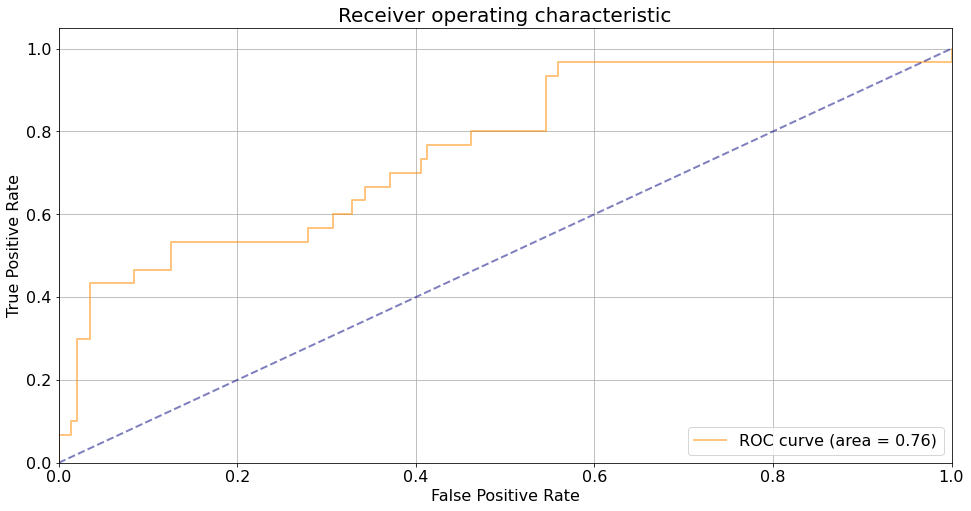

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

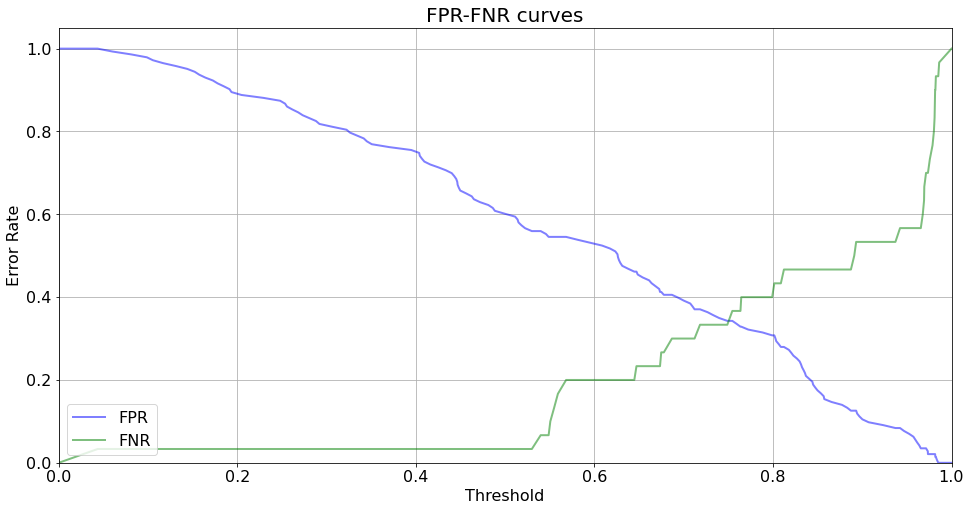

In [73]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [74]:
from catboost.utils import select_threshold

print(select_threshold(model=model, data=eval_pool, FNR=0.01))
print(select_threshold(model=model, data=eval_pool, FPR=0.01))

0.0
0.9836911238918495


In [75]:
confusion_matrix(y_validation, model.predict(data=X_validation))

array([[57, 86],
       [ 1, 29]])

##LightGBM implementation

In [76]:
!pip install flaml


     |████████████████████████████████| 81kB 3.2MB/s 
     |████████████████████████████████| 22.3MB 1.5MB/s 
     |████████████████████████████████| 1.8MB 36.0MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


NameError: ignored

In [78]:
data = pd.read_csv('/content/covid_data.csv')
data=data.drop('Unnamed: 0', axis=1)
X = data.drop('Ab_ind', axis=1)  
Y = data['Ab_ind'] 
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size = 0.20,
                                                    stratify = Y, 
                                                    random_state = 42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [81]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

In [79]:
settings = {
    "time_budget": 120, # total running time in seconds
    "metric": 'f1', 
    "estimator_list": ['lgbm'], # list of ML learners; we tune lightgbm in this example
    "task": 'classification', # task type    
    "log_file_name": 'AB_ind_experiment.log', # flaml log file
}

In [82]:
'''The main flaml automl API'''
automl.fit(X_train = X_train, y_train = y_train, **settings)

[flaml.automl: 02-25 04:06:01] {853} INFO - Evaluation method: cv
[flaml.automl: 02-25 04:06:01] {573} INFO - Using StratifiedKFold
[flaml.automl: 02-25 04:06:01] {874} INFO - Minimizing error metric: 1-f1
[flaml.automl: 02-25 04:06:01] {894} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 02-25 04:06:01] {953} INFO - iteration 0  current learner lgbm
[flaml.automl: 02-25 04:06:01] {1107} INFO -  at 0.1s,	best lgbm's error=1.0000,	best lgbm's error=1.0000
[flaml.automl: 02-25 04:06:01] {953} INFO - iteration 1  current learner lgbm
[flaml.automl: 02-25 04:06:01] {1107} INFO -  at 0.2s,	best lgbm's error=1.0000,	best lgbm's error=1.0000
[flaml.automl: 02-25 04:06:01] {953} INFO - iteration 2  current learner lgbm
[flaml.automl: 02-25 04:06:01] {1107} INFO -  at 0.2s,	best lgbm's error=0.9418,	best lgbm's error=0.9418
[flaml.automl: 02-25 04:06:01] {953} INFO - iteration 3  current learner lgbm
[flaml.automl: 02-25 04:06:01] {1107} INFO -  at 0.3s,	best lgbm's error=0.9

In [84]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))
print('roc_auc', '=', 1 - sklearn_metric_loss_score('roc_auc', y_pred_proba, y_test))
print('log_loss', '=', sklearn_metric_loss_score('log_loss', y_pred_proba, y_test))
print('f1', '=', 1 - sklearn_metric_loss_score('f1', y_pred, y_test))

NameError: ignored

In [83]:
automl.model

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.803394625599278, importance_type='split',
               learning_rate=1.0, max_bin=15, max_depth=-1,
               min_child_samples=20, min_child_weight=0.27471338035949866,
               min_split_gain=0.0, n_estimators=39, n_jobs=-1, num_leaves=4,
               objective='binary', random_state=None,
               reg_alpha=1.2328828689801802e-07,
               reg_lambda=0.0025492160221007817, silent=True,
               subsample=0.9325513738496009, subsample_for_bin=200000,
               subsample_freq=0)

In [85]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, train_loss_history = \
    get_output_from_log(filename = settings['log_file_name'], time_budget = 60)

for config in config_history:
    print(config)

{'Current Learner': 'lgbm', 'Current Sample': 690, 'Current Hyper-parameters': {'n_estimators': 4, 'max_leaves': 4, 'min_child_weight': 20.0, 'learning_rate': 0.1, 'subsample': 1.0, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 1e-10, 'reg_lambda': 1.0}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'max_leaves': 4, 'min_child_weight': 20.0, 'learning_rate': 0.1, 'subsample': 1.0, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 1e-10, 'reg_lambda': 1.0}}
{'Current Learner': 'lgbm', 'Current Sample': 690, 'Current Hyper-parameters': {'n_estimators': 4.0, 'max_leaves': 4.0, 'min_child_weight': 20.0, 'learning_rate': 0.46335414315327306, 'subsample': 0.9339389930838808, 'log_max_bin': 10.0, 'colsample_bytree': 0.9904286645657556, 'reg_alpha': 2.841147337412889e-10, 'reg_lambda': 0.12000833497054482}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4.0, 'max_leaves': 4.0, 'min_child_weight': 20.0, 'learning_rate': 0.463354143153273

In [129]:
from lightgbm import LGBMClassifier
lg=LGBMClassifier(class_weight={0:.95, 1:110},
               boosting_type='gbdt', 
               colsample_bytree=0.803394625599278, importance_type='split',
               learning_rate=1.0, max_bin=15, max_depth=-1,
               min_child_samples=20, min_child_weight=0.27471338035949866,
               min_split_gain=0.0, n_estimators=39, n_jobs=-1, num_leaves=4,
               objective='binary', random_state=None,
               reg_alpha=1.2328828689801802e-07,
               reg_lambda=0.0025492160221007817, silent=True,
               subsample=0.9325513738496009, subsample_for_bin=200000,
               subsample_freq=0)
lg.fit(X_train,y_train)
ypred = lg.predict(X_test)
print('With score : ',confusion_matrix(y_test,ypred))

With score :  [[107  36]
 [ 15  15]]


With score :  [[52 91]
 [ 1 29]]


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Ab_ind',axis=1), df['Ab_ind'], test_size=.2, random_state=1234)

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
def all_estimators_pipline(x_train, y_train, x_test, y_test):
   
    #Logistic Regression
    log_reg = LogisticRegression()
    log_reg.fit(x_train, y_train)
    log_reg_pred = log_reg.predict(x_test)
    print('LR conf{0}'.format(confusion_matrix(y_test,log_reg_pred)))
    
    #svm
    sv_clf = SVC()
    sv_clf.fit(x_train, y_train)
    sv_clf_pred = sv_clf.predict(x_test)
    print('SVM conf{0}'.format(confusion_matrix(y_test, sv_clf_pred)))
    
    # K Neighbors Classifier

    kn_clf = KNeighborsClassifier(n_neighbors=6)
    kn_clf.fit(x_train, y_train)
    kn_pred = kn_clf.predict(x_test)
    print('Kn conf{0}'.format(confusion_matrix(y_test, kn_pred)))
    # Decision Tree Classifier

    dt_clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0, criterion='entropy')
    dt_clf.fit(x_train, y_train)
    dt_pred = dt_clf.predict(x_test)
    print('DT conf{0}'.format(confusion_matrix(y_test, dt_pred)))
    
    # RandomForestClassifier

    r_clf = RandomForestClassifier(max_features=0.5, max_depth=15, random_state=1)
    r_clf.fit(x_train, y_train)
    r_pred = r_clf.predict(x_test)
    print('RF conf{0}'.format(confusion_matrix(y_test, r_pred)))
  
    #xgb
    gradientboost_clf = GradientBoostingClassifier(max_depth=2, random_state=1)
    gradientboost_clf.fit(x_train,y_train)
    gradientboost_pred = gradientboost_clf.predict(x_test)
    print('XGB conf{0}'.format(confusion_matrix(y_test, gradientboost_pred)))
    
    #  lightgbm 

    lgb_clf = lightgbm.LGBMClassifier(max_depth=2, random_state=4)
    lgb_clf.fit(x_train,y_train)
    lgb_pred = lgb_clf.predict(x_test)
    print('LGB conf{0}'.format(confusion_matrix(y_test, lgb_pred)))
    
    # # CatBoostClassifier

    # cat_clf = CatBoostClassifier()
    # cat_clf.fit(x_train,y_train)
    # cat_pred = cat_clf.predict(x_test)
    # print('CBC conf{0}'.format(confusion_matrix(y_test, cat_pred)))

# Новый раздел

In [ ]:
all_estimators_pipline(x_train, y_train, x_test, y_test)

LR conf[[137   6]
 [ 22   8]]
SVM conf[[139   4]
 [ 26   4]]
Kn conf[[139   4]
 [ 26   4]]
DT conf[[143   0]
 [ 30   0]]
RF conf[[136   7]
 [ 24   6]]
XGB conf[[136   7]
 [ 19  11]]
LGB conf[[137   6]
 [ 21   9]]


In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
import matplotlib as mpl

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
cleaned_df = df.copy()

In [ ]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Ab_ind'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Ab_ind'))
test_labels = np.array(test_df.pop('Ab_ind'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [ ]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (552,)
Validation labels shape: (138,)
Test labels shape: (173,)
Training features shape: (552, 24)
Validation features shape: (138, 24)
Test features shape: (173, 24)


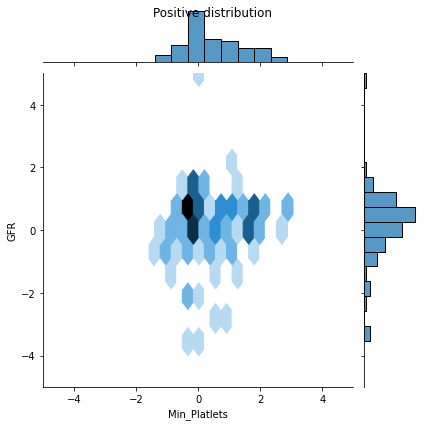

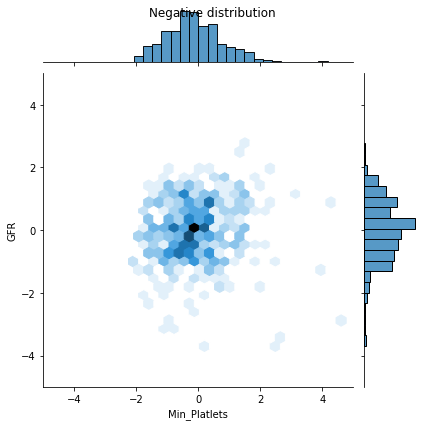

In [ ]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['Min_Platlets'], pos_df['GFR'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['Min_Platlets'], neg_df['GFR'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [ ]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                400       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 417
Trainable params: 417
Non-trainable params: 0
_________________________________________________________________


In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.1994


In [ ]:
initial_bias = np.log([pos/neg])
initial_bias

array([-1.57507027])

In [ ]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.13542745],
       [0.05980507],
       [0.05974779],
       [0.10283461],
       [0.18274924],
       [0.11486146],
       [0.09984952],
       [0.11691177],
       [0.03027856],
       [0.18822464]], dtype=float32)

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.4236


In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [ ]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

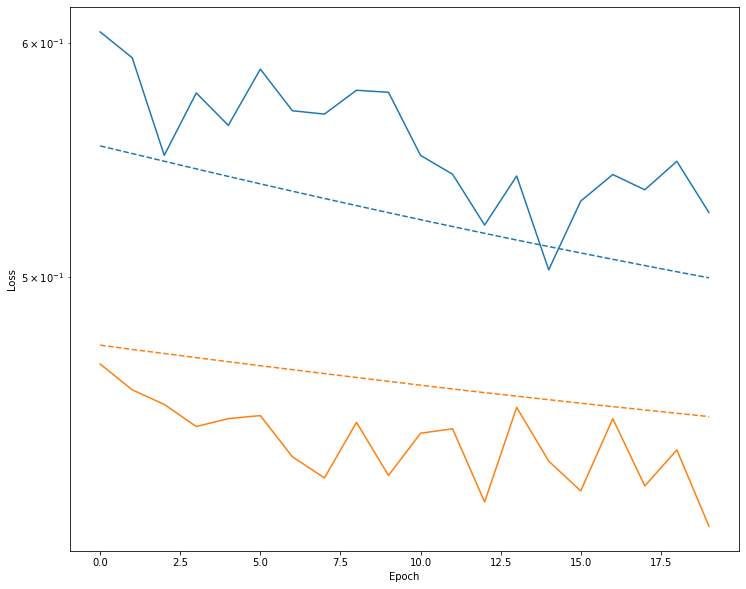

In [ ]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.4608 - tp: 1.0000 - fp: 3.0000 - tn: 575.0000 - fn: 111.0000 - accuracy: 0.8348 - precision: 0.2500 - recall: 0.0089 - auc: 0.5958 - val_loss: 0.4743 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 113.0000 - val_fn: 25.0000 - val_accuracy: 0.8188 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6423
Epoch 2/100
1/1 [==============================] - 0s 53ms/step - loss: 0.4579 - tp: 2.0000 - fp: 3.0000 - tn: 462.0000 - fn: 85.0000 - accuracy: 0.8406 - precision: 0.4000 - recall: 0.0230 - auc: 0.5583 - val_loss: 0.4728 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 113.0000 - val_fn: 25.0000 - val_accuracy: 0.8188 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6430
Epoch 3/100
1/1 [==============================] - 0s 51ms/step - loss: 0.4616 - tp: 0.0000e+00 - fp: 4.0000 - tn: 461.0000 - fn: 87.0000 - accuracy: 0.8351 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

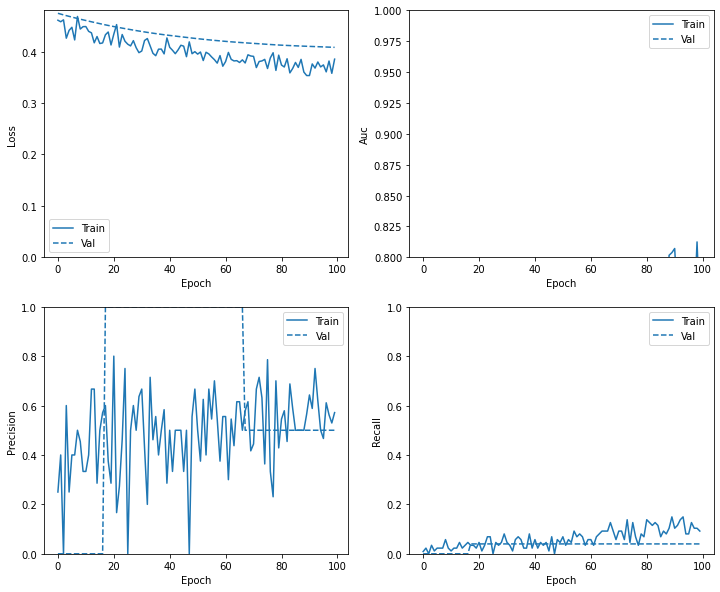

In [ ]:
plot_metrics(baseline_history)

In [ ]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.5029137134552002
tp :  2.0
fp :  2.0
tn :  135.0
fn :  34.0
accuracy :  0.7919074892997742
precision :  0.5
recall :  0.0555555559694767
auc :  0.7107664346694946

Legitimate Transactions Detected (True Negatives):  135
Legitimate Transactions Incorrectly Detected (False Positives):  2
Fraudulent Transactions Missed (False Negatives):  34
Fraudulent Transactions Detected (True Positives):  2
Total Fraudulent Transactions:  36


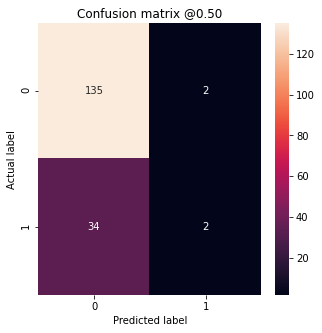

In [ ]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

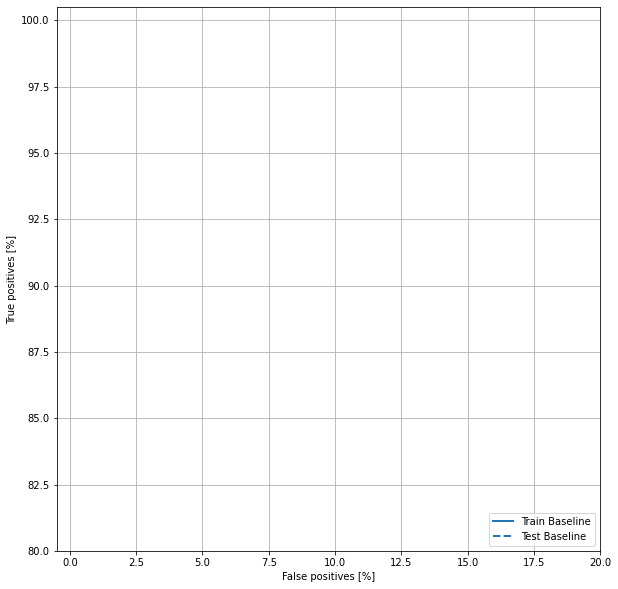

In [ ]:
import sklearn
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.60
Weight for class 1: 2.92


In [ ]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 1.0125 - tp: 6.0000 - fp: 8.0000 - tn: 594.0000 - fn: 117.0000 - accuracy: 0.8276 - precision: 0.4286 - recall: 0.0488 - auc: 0.6375 - val_loss: 0.4741 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 113.0000 - val_fn: 25.0000 - val_accuracy: 0.8188 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6372
Epoch 2/100
1/1 [==============================] - 0s 54ms/step - loss: 0.9691 - tp: 4.0000 - fp: 2.0000 - tn: 463.0000 - fn: 83.0000 - accuracy: 0.8460 - precision: 0.6667 - recall: 0.0460 - auc: 0.6334 - val_loss: 0.4724 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 113.0000 - val_fn: 25.0000 - val_accuracy: 0.8188 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6386
Epoch 3/100
1/1 [==============================] - 0s 49ms/step - loss: 1.0906 - tp: 2.0000 - fp: 6.0000 - tn: 459.0000 - fn: 85.0000 - accuracy: 0.8351 - precision: 0.2500 - recall: 0.0230 - auc: 0.5475 - val

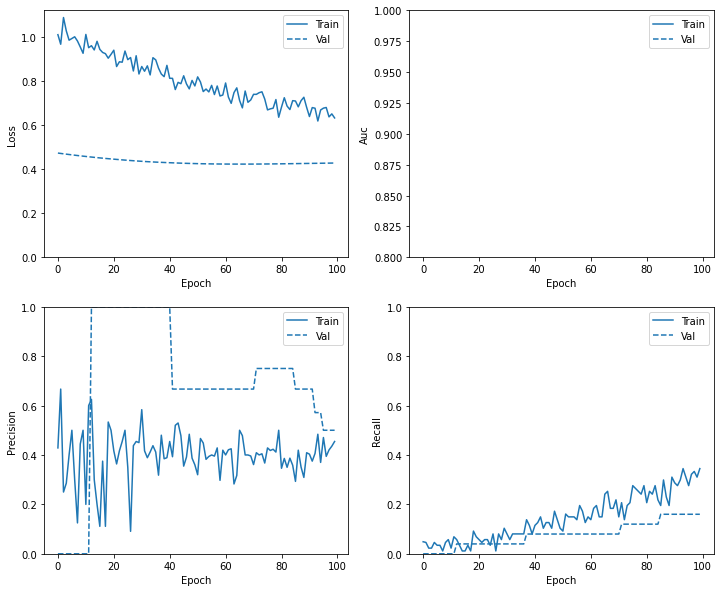

In [ ]:
plot_metrics(weighted_history)

In [ ]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.4984341263771057
tp :  9.0
fp :  8.0
tn :  129.0
fn :  27.0
accuracy :  0.7976878881454468
precision :  0.529411792755127
recall :  0.25
auc :  0.6906933784484863

Legitimate Transactions Detected (True Negatives):  129
Legitimate Transactions Incorrectly Detected (False Positives):  8
Fraudulent Transactions Missed (False Negatives):  27
Fraudulent Transactions Detected (True Positives):  9
Total Fraudulent Transactions:  36


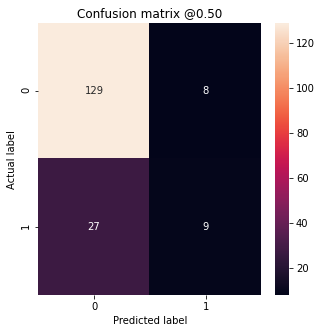

In [ ]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

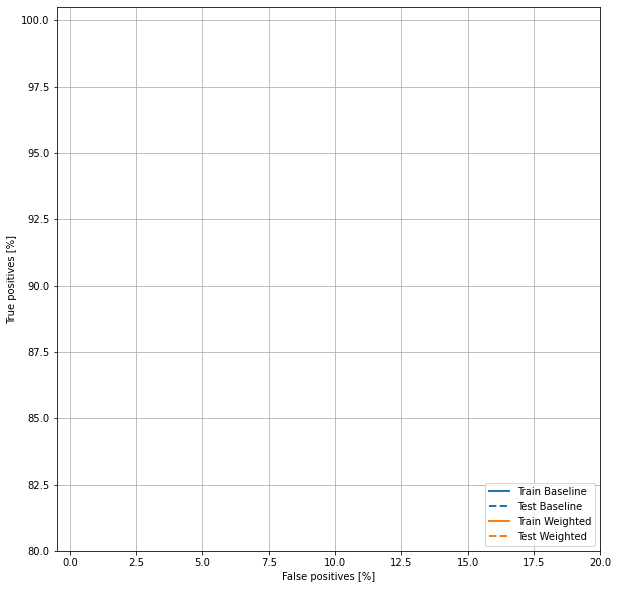

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

In [ ]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [ ]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(465, 24)

In [ ]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(930, 24)

In [ ]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [ ]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [ 0.90835212  1.38519389 -0.48665697 -0.30624553 -0.14946212 -1.08711461
 -1.36011477  1.06361371 -0.94705186 -0.22677868 -0.11333153 -0.08543577
 -0.12126781 -1.06450637 -0.59947858 -0.34527434 -0.57147071  4.52576062
 -0.16713157 -0.47609523 -0.82639387 -0.10482848 -2.49474133 -0.22686201]

Label:  1


In [ ]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [ ]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.48486328125


In [ ]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

1.0

In [ ]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.7384 - tp: 331.0000 - fp: 277.0000 - tn: 907.0000 - fn: 706.0000 - accuracy: 0.5574 - precision: 0.5444 - recall: 0.3192 - auc: 0.6114 - val_loss: 0.5565 - val_tp: 7.0000 - val_fp: 13.0000 - val_tn: 100.0000 - val_fn: 18.0000 - val_accuracy: 0.7754 - val_precision: 0.3500 - val_recall: 0.2800 - val_auc: 0.6393
Epoch 2/100
1/1 [==============================] - 0s 65ms/step - loss: 0.7581 - tp: 326.0000 - fp: 280.0000 - tn: 778.0000 - fn: 664.0000 - accuracy: 0.5391 - precision: 0.5380 - recall: 0.3293 - auc: 0.5739 - val_loss: 0.5561 - val_tp: 7.0000 - val_fp: 13.0000 - val_tn: 100.0000 - val_fn: 18.0000 - val_accuracy: 0.7754 - val_precision: 0.3500 - val_recall: 0.2800 - val_auc: 0.6448
Epoch 3/100
1/1 [==============================] - 0s 58ms/step - loss: 0.7137 - tp: 362.0000 - fp: 252.0000 - tn: 787.0000 - fn: 647.0000 - accuracy: 0.5610 - precision: 0.5896 - recall: 0.3588 - auc: 0.6151 - val_loss: 0.5558 - 

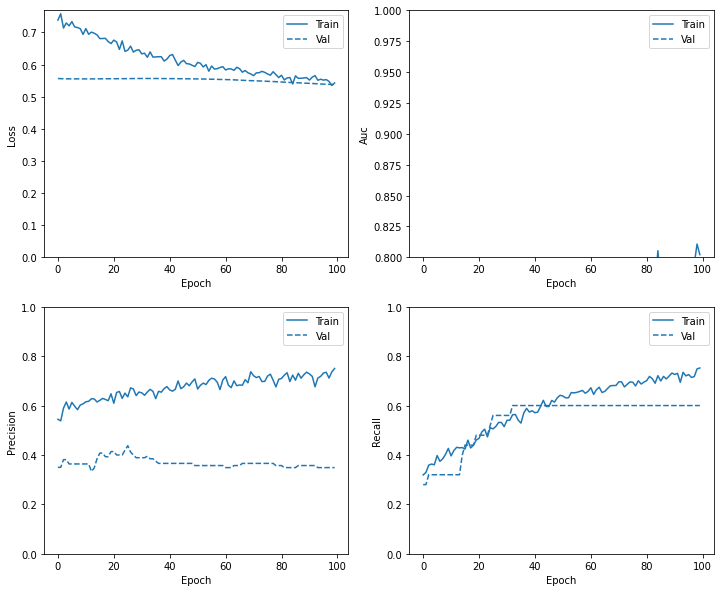

In [ ]:
plot_metrics(resampled_history)

In [ ]:
tf.random.set_seed(1222)
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - 3s 87ms/step - loss: 0.7191 - tp: 4352.0000 - fp: 2900.3333 - tn: 8540.1905 - fn: 6810.9524 - accuracy: 0.5677 - precision: 0.5936 - recall: 0.3792 - auc: 0.6187 - val_loss: 0.5556 - val_tp: 11.0000 - val_fp: 17.0000 - val_tn: 96.0000 - val_fn: 14.0000 - val_accuracy: 0.7754 - val_precision: 0.3929 - val_recall: 0.4400 - val_auc: 0.7030
Epoch 2/1000
20/20 [==============================] - 0s 24ms/step - loss: 0.6553 - tp: 5702.0952 - fp: 3177.6667 - tn: 8088.3810 - fn: 5462.3333 - accuracy: 0.6099 - precision: 0.6385 - recall: 0.5004 - auc: 0.6754 - val_loss: 0.5562 - val_tp: 15.0000 - val_fp: 26.0000 - val_tn: 87.0000 - val_fn: 10.0000 - val_accuracy: 0.7391 - val_precision: 0.3659 - val_recall: 0.6000 - val_auc: 0.7375
Epoch 3/1000
20/20 [==============================] - 0s 23ms/step - loss: 0.6115 - tp: 6938.2857 - fp: 3234.6190 - tn: 7939.0000 - fn: 4318.5714 - accuracy: 0.6611 - precision: 0.6812 - recall: 0.6109 - auc: 0.725

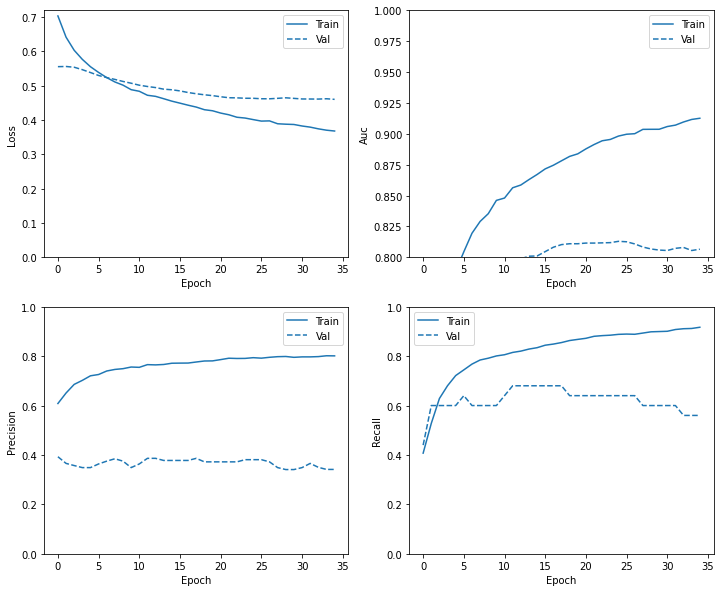

In [ ]:
plot_metrics(resampled_history)

In [ ]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.6593720316886902
tp :  21.0
fp :  25.0
tn :  112.0
fn :  15.0
accuracy :  0.7687861323356628
precision :  0.45652174949645996
recall :  0.5833333134651184
auc :  0.7213098406791687

Legitimate Transactions Detected (True Negatives):  112
Legitimate Transactions Incorrectly Detected (False Positives):  25
Fraudulent Transactions Missed (False Negatives):  15
Fraudulent Transactions Detected (True Positives):  21
Total Fraudulent Transactions:  36


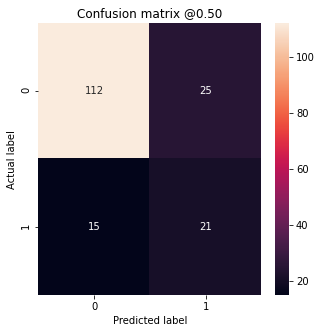

In [ ]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

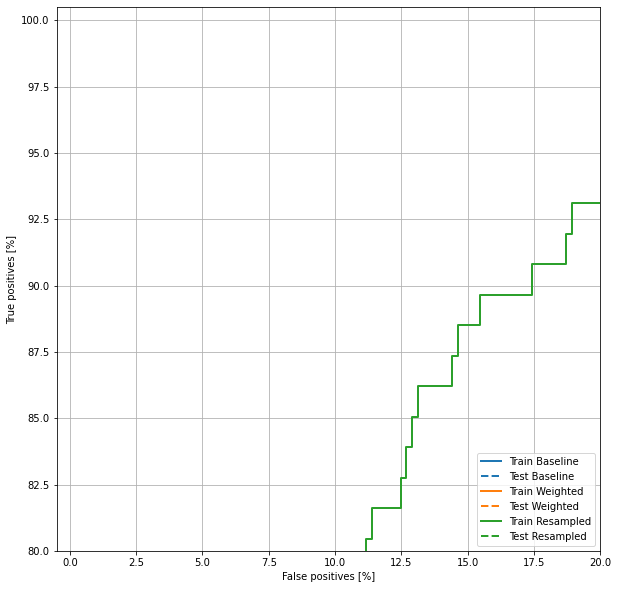

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')